In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import MT5ForConditionalGeneration, AutoTokenizer
from datasets import load_dataset
from evaluate import load
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from tqdm import tqdm 
from scipy.stats import kurtosis
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean
from scipy.stats import gmean
from evaluate import load
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from collections import Counter
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem.api import StemmerI
from nltk.stem.porter import PorterStemmer
from nltk.corpus.reader.wordnet import WordNetCorpusReader
from nltk.corpus import wordnet
from typing import Iterable, Callable, List, Optional
from collections import Counter
from nltk.util import ngrams
from typing import List, Tuple

import matplotlib.pyplot as plt 
import evaluate
import torch
import time
import nltk
import numpy as np
import torch.nn.functional as F
import math

nltk.download('wordnet')
nltk.download('omw-1.4')
bertscore = load("bertscore")

/Users/jinhyunpark/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jinhyunpark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jinhyunpark/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Define metrics

In [2]:
def adjusted_rouge_score(
    reference_tokens: List[str],
    candidate_tokens: List[str],
    token_probabilities: List[float],
    ngram_orders: List[int] = [1, 2],
    epsilon: float = 1e-8
    ) -> dict:
    """
    Calculates adjusted ROUGE scores incorporating token probabilities.

    Args:
        candidate_tokens (List[str]): List of tokens in the candidate text.
        reference_tokens (List[str]): List of tokens in the reference text.
        token_probabilities (List[float]): Probabilities for each token in the candidate text.
        ngram_orders (List[int]): List of n-gram orders to compute (e.g., [1, 2] for ROUGE-1 and ROUGE-2).
        epsilon (float): Small value to avoid division by zero.

    Returns:
        dict: Adjusted ROUGE scores for each specified n-gram order and ROUGE-L.
    """
    # Ensure token probabilities match the candidate tokens
    if len(candidate_tokens) != len(token_probabilities):
        raise ValueError("Length of token_probabilities must match length of candidate_tokens.")

    scores = {}

    # Compute ROUGE-N scores
    for n in ngram_orders:
        # Generate n-grams
        candidate_ngrams = list(ngrams(candidate_tokens, n))
        reference_ngrams = list(ngrams(reference_tokens, n))

        # Calculate n-gram probabilities for candidate n-grams
        candidate_ngram_probs = []
        for i in range(len(candidate_ngrams)):
            # Get indices of tokens in the n-gram
            indices = range(i, i + n)
            probs = [token_probabilities[idx] for idx in indices]
            # Calculate geometric mean of probabilities
            ngram_prob = np.exp(np.mean(np.log(np.array(probs) + epsilon)))
            candidate_ngram_probs.append(ngram_prob)

        # Count n-grams in reference
        reference_counts = Counter(reference_ngrams)
        total_reference_ngrams = sum(reference_counts.values())

        # Identify overlapping n-grams
        overlapping_indices = []
        for idx, ngram in enumerate(candidate_ngrams):
            if ngram in reference_counts and reference_counts[ngram] > 0:
                overlapping_indices.append(idx)
                reference_counts[ngram] -= 1  # Decrement to handle multiple occurrences

        # Calculate weighted overlapping n-gram probabilities
        weighted_overlap = sum(candidate_ngram_probs[idx] for idx in overlapping_indices)

        # Calculate weighted total n-gram probabilities in candidate
        weighted_total_candidate = sum(candidate_ngram_probs)

        # Adjusted precision and recall
        precision = weighted_overlap / (weighted_total_candidate + epsilon)
        recall = weighted_overlap / (total_reference_ngrams + epsilon)

        # Adjusted F1-score
        if precision + recall > 0:
            f1_score = 2 * precision * recall / (precision + recall)
        else:
            f1_score = 0.0

        # Store scores
        scores[f'rouge-{n}'] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score
        }

    # Compute ROUGE-L score (Longest Common Subsequence)
    rouge_l_score = _adjusted_rouge_l_score(
        candidate_tokens,
        reference_tokens,
        token_probabilities,
        epsilon
    )
    scores['rouge-l'] = rouge_l_score

    return scores

def _adjusted_rouge_l_score(
    candidate_tokens: List[str],
    reference_tokens: List[str],
    token_probabilities: List[float],
    epsilon: float = 1e-8
) -> dict:
    """
    Calculates adjusted ROUGE-L score incorporating token probabilities.
    """
    # Calculate the weighted longest common subsequence (LCS)
    lcs_length, lcs_indices = _weighted_lcs(candidate_tokens, reference_tokens, token_probabilities)

    # Sum of token probabilities in candidate
    total_candidate_prob = sum(token_probabilities)

    # Total number of tokens in reference
    total_reference_tokens = len(reference_tokens)

    # Adjusted precision and recall
    weighted_lcs_prob = sum(token_probabilities[idx] for idx in lcs_indices)
    precision = weighted_lcs_prob / (total_candidate_prob + epsilon)
    recall = weighted_lcs_prob / (total_reference_tokens + epsilon)

    # Adjusted F1-score
    if precision + recall > 0:
        f1_score = 2 * precision * recall / (precision + recall)
    else:
        f1_score = 0.0

    return {
        'precision': precision,
        'recall': recall,
        'f1-score': f1_score
    }

def _weighted_lcs(
    candidate_tokens: List[str],
    reference_tokens: List[str],
    token_probabilities: List[float]
) -> Tuple[int, List[int]]:
    """
    Calculates the weighted longest common subsequence (LCS) between candidate and reference tokens.

    Returns:
        Tuple[int, List[int]]: Length of LCS and list of indices in candidate_tokens that are part of the LCS.
    """
    m = len(candidate_tokens)
    n = len(reference_tokens)

    # Initialize DP table
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    backtrack = [[None] * (n + 1) for _ in range(m + 1)]

    # Fill DP table
    for i in range(m):
        for j in range(n):
            if candidate_tokens[i] == reference_tokens[j]:
                dp[i + 1][j + 1] = dp[i][j] + token_probabilities[i]
                backtrack[i + 1][j + 1] = 'diag'
            else:
                if dp[i][j + 1] >= dp[i + 1][j]:
                    dp[i + 1][j + 1] = dp[i][j + 1]
                    backtrack[i + 1][j + 1] = 'up'
                else:
                    dp[i + 1][j + 1] = dp[i + 1][j]
                    backtrack[i + 1][j + 1] = 'left'

    # Backtrack to find LCS indices
    i, j = m, n
    lcs_indices = []
    while i > 0 and j > 0:
        if backtrack[i][j] == 'diag':
            lcs_indices.append(i - 1)
            i -= 1
            j -= 1
        elif backtrack[i][j] == 'up':
            i -= 1
        else:
            j -= 1

    lcs_indices.reverse()
    lcs_length = dp[m][n]

    return lcs_length, lcs_indices


In [3]:
def adjusted_meteor_score(
    references: Iterable[Iterable[str]],
    hypothesis: Iterable[str],
    token_probabilities: List[float],
    preprocess: Callable[[str], str] = str.lower,
    stemmer: Optional[StemmerI] = PorterStemmer(),
    wordnet: Optional[WordNetCorpusReader] = wordnet,
    alpha: float = 0.9,
    beta: float = 3.0,
    gamma: float = 0.5
    ) -> float:
    """
    Calculate the adjusted METEOR score for a hypothesis against references, incorporating token probabilities.
    
    Args:
        references (Iterable[Iterable[str]]): A list of reference sentences, each as a list of tokens.
        hypothesis (Iterable[str]): The hypothesis sentence as a list of tokens.
        token_probabilities (List[float]): List of probabilities for each token in the hypothesis.
        preprocess (Callable[[str], str]): Function to preprocess tokens (default is str.lower).
        stemmer (StemmerI): An NLTK stemmer (default is PorterStemmer()).
        wordnet (WordNetCorpusReader): NLTK WordNet corpus reader (default is nltk.corpus.wordnet).
        alpha (float): Parameter for controlling the weight of precision and recall (default is 0.9).
        beta (float): Parameter for controlling the penalty for fragmentation (default is 3.0).
        gamma (float): Parameter for controlling the weight of the penalty (default is 0.5).
        
    Returns:
        float: The adjusted METEOR score.
    """
    # Ensure the token probabilities list matches the length of the hypothesis
    if len(hypothesis) != len(token_probabilities):
        raise ValueError("Length of token_probabilities must match length of hypothesis.")

    # Preprocess hypothesis tokens
    hypothesis = [preprocess(token) for token in hypothesis]
    
    # Preprocess reference tokens
    references = [[preprocess(token) for token in ref] for ref in references]
    
    # Apply stemming if stemmer is provided
    if stemmer:
        hypothesis = [stemmer.stem(token) for token in hypothesis]
        references = [[stemmer.stem(token) for token in ref] for ref in references]
    
    # Initialize maximum score
    max_score = 0.0
    
    # Calculate adjusted METEOR score for each reference
    for reference in references:
        score = _single_reference_meteor(
            reference,
            hypothesis,
            token_probabilities,
            wordnet,
            alpha,
            beta,
            gamma
        )
        if score > max_score:
            max_score = score
            
    return max_score

def _single_reference_meteor(
    reference: List[str],
    hypothesis: List[str],
    token_probabilities: List[float],
    wordnet: Optional[WordNetCorpusReader],
    alpha: float,
    beta: float,
    gamma: float
) -> float:
    """
    Compute adjusted METEOR score for a single reference.
    """
    # Match unigrams
    matches, matched_indices = _match_unigrams(reference, hypothesis, wordnet)
    
    # Calculate weighted precision and recall
    sum_matched_probabilities = sum(token_probabilities[i] for i in matched_indices)
    sum_hypothesis_probabilities = sum(token_probabilities)
    
    precision = sum_matched_probabilities / sum_hypothesis_probabilities if sum_hypothesis_probabilities > 0 else 0.0
    recall = sum_matched_probabilities / len(reference) if len(reference) > 0 else 0.0
    
    # F-mean calculation
    if precision + recall > 0:
        f_mean = (1 + alpha) * precision * recall / (alpha * precision + recall)
    else:
        f_mean = 0.0
    
    # Penalty for fragmentation
    penalty = _compute_penalty(matched_indices, beta, gamma)
    
    # Adjusted METEOR score
    adjusted_meteor = f_mean * (1 - penalty)
    
    return adjusted_meteor

def _match_unigrams(
    reference: List[str],
    hypothesis: List[str],
    wordnet: Optional[WordNetCorpusReader]
    ) -> (List[str], List[int]):
    """
    Match unigrams between reference and hypothesis, considering exact matches and synonyms.
    """
    # Create a set for reference tokens
    reference_set = set(reference)
    
    # Exact matches
    matches = []
    matched_indices = []
    unmatched_hypothesis = []
    
    for idx, token in enumerate(hypothesis):
        if token in reference_set:
            matches.append(token)
            matched_indices.append(idx)
        else:
            unmatched_hypothesis.append((idx, token))
    
    # Synonym matching if wordnet is provided
    if wordnet:
        # Get synonyms for unmatched reference tokens
        reference_synonyms = _get_synonyms(reference_set - set(matches), wordnet)
        
        for idx, token in unmatched_hypothesis:
            token_synonyms = _get_synonyms({token}, wordnet)
            if reference_synonyms & token_synonyms:
                matches.append(token)
                matched_indices.append(idx)
    
    return matches, matched_indices

def _get_synonyms(tokens: set, wordnet: WordNetCorpusReader) -> set:
    """
    Get synonyms for a set of tokens using WordNet.
    """
    synonyms = set()
    for token in tokens:
        synsets = wordnet.synsets(token)
        for synset in synsets:
            for lemma in synset.lemmas():
                synonyms.add(lemma.name())
    return synonyms

def _compute_penalty(matched_indices: List[int], beta: float, gamma: float) -> float:
    """
    Compute fragmentation penalty.
    """
    if not matched_indices:
        return 0.0
    
    # Sort indices
    matched_indices.sort()
    
    # Count chunks
    chunks = 1
    for i in range(1, len(matched_indices)):
        if matched_indices[i] != matched_indices[i - 1] + 1:
            chunks += 1
    
    # Penalty calculation
    penalty = gamma * (chunks / len(matched_indices)) ** beta
    
    return penalty

In [4]:
def adjusted_bleu_score(reference_tokens, candidate_tokens, token_probabilities, max_n=4, epsilon=1e-8):
    """
    Calculates the adjusted BLEU score incorporating token probabilities.

    Args:
        candidate_tokens (list): List of tokens in the candidate sentence.
        reference_tokens (list): List of tokens in the reference sentence.
        token_probabilities (list): List of probabilities for each token in the candidate sentence.
        max_n (int): Maximum n-gram order to consider (default is 4).
        epsilon (float): Small value to avoid math errors with logs (default is 1e-8).

    Returns:
        float: Adjusted BLEU score.
    """

    # Initialize lists to hold precision scores for each n-gram order
    precision_scores = []

    # Calculate brevity penalty components
    c = len(candidate_tokens)
    r = len(reference_tokens)

    # For each n-gram order from 1 to max_n
    for n in range(1, max_n + 1):
        # Generate n-grams for candidate and reference sentences
        candidate_ngrams = list(ngrams(candidate_tokens, n))
        reference_ngrams = list(ngrams(reference_tokens, n))

        # Calculate n-gram probabilities using geometric mean
        candidate_ngram_probs = []
        for i in range(len(candidate_ngrams)):
            # Get token indices for the n-gram
            indices = range(i, i + n)
            # Get probabilities for tokens in the n-gram
            probs = [token_probabilities[idx] for idx in indices]
            # Calculate geometric mean of probabilities
            ngram_prob = math.exp(sum(math.log(p + epsilon) for p in probs) / n)
            candidate_ngram_probs.append(ngram_prob)

        # Count n-grams in candidate and reference
        reference_counts = Counter(reference_ngrams)
        candidate_counts = Counter(candidate_ngrams)

        # Calculate weighted matches and total weights
        weighted_match = 0.0
        weighted_total = 0.0

        for ngram, count in candidate_counts.items():
            # Get the number of times this n-gram matches the reference
            match_count = min(count, reference_counts.get(ngram, 0))
            # Get indices of this n-gram in candidate_ngrams
            indices = [i for i, x in enumerate(candidate_ngrams) if x == ngram]
            # Sum probabilities for matching n-grams
            for idx in indices[:match_count]:
                weighted_match += candidate_ngram_probs[idx]
            # Sum probabilities for all candidate n-grams
            for idx in indices:
                weighted_total += candidate_ngram_probs[idx]

        # Avoid division by zero
        if weighted_total == 0:
            precision = 0.0
        else:
            precision = weighted_match / weighted_total

        # Add epsilon to avoid math domain error when taking log(0)
        precision_scores.append(precision + epsilon)

    # Calculate geometric mean of precision scores
    log_precisions = [math.log(p) for p in precision_scores]
    avg_log_precision = sum(log_precisions) / max_n
    precision_score = math.exp(avg_log_precision)

    # Calculate brevity penalty
    if c > r:
        bp = 1
    else:
        bp = math.exp(1 - float(r) / c)

    # Calculate adjusted BLEU score
    adjusted_bleu = bp * precision_score

    return adjusted_bleu

### Datasets

In [5]:
# english to X is only possible for T5
from datasets import load_dataset, load_from_disk

# ds_de_en = load_dataset("wmt/wmt14", "de-en")
# ds_fr_en = load_dataset("wmt/wmt15", "fr-en")
# ds_ro_en = load_dataset("wmt/wmt16", "ro-en")

# ds_de_en.save_to_disk("../wmt14_de_en")
# ds_fr_en.save_to_disk("../wmt15_fr_en")
# ds_ro_en.save_to_disk("../wmt16_ro_en")

ds_de_en = load_from_disk("../wmt14_de_en")
ds_fr_en = load_from_disk("../wmt15_fr_en")
ds_ro_en = load_from_disk("../wmt16_ro_en")

### Models

In [6]:
t5_tokenizer_small = AutoTokenizer.from_pretrained('t5-small')
t5_model_small = AutoModelForSeq2SeqLM.from_pretrained('t5-small')
print("Done with small")

t5_tokenizer_base = AutoTokenizer.from_pretrained('t5-base')
t5_model_base = AutoModelForSeq2SeqLM.from_pretrained('t5-base')
print("Done with base")

Done with small
Done with base


### Init

In [7]:
def calculate_probs_from_logits(logits):
    return F.softmax(logits, dim=-1)

def generate_output_with_probs(model, tokenizer, example, top_k=5):
    '''
    - High Kurtosis: An indicator that the data has heavy tails or outliers.
    - Low Kurtosis:  An indicator that the data has thin tails and lacks outliers.
    '''
    inputs = tokenizer.encode(example, return_tensors="pt")
    output_ids = model.generate(inputs, max_new_tokens=np.inf, return_dict_in_generate=True, output_scores=True, return_legacy_cache=False)
    output_tokens = output_ids.sequences[0]
    output_probs = []
    output_kurtosis = []

    # Retrieve probabilities for each token
    for i, token_id in tqdm(enumerate(output_tokens)):
        if i == 0 or i == len(output_tokens) - 1:  # Skip the first and last tokens
            continue
        probs = calculate_probs_from_logits(output_ids.scores[i - 1])[0]
        token_prob = probs[token_id].item()  

        top_probs, _ = torch.topk(probs, 1000)
        kurt = kurtosis(top_probs)

        output_probs.append(token_prob)
        output_kurtosis.append(kurt)
        
    decoded_output = tokenizer.decode(output_tokens, skip_special_tokens=True)
    return decoded_output, np.array(output_probs), np.array(output_kurtosis)

### 1. Generate translations (English to German)

--------------- Sample 0 ---------------


11it [00:00, 1754.14it/s]


[Sentences]
   Input: translate English to German: Resumption of the session
   True Translation: Wiederaufnahme der Sitzungsperiode
   Predicted Translation: Wiederaufnahme der Sitzungsperiode

[Scores]
   Adjusted BLEU score: 1.00000001
   Adjusted METEOR score: 0.9984050297064493
   ROUGE score: {'rouge-1': {'precision': 0.999999998886753, 'recall': 0.9980814214712987, 'f1-score': 0.9990397890605816}, 'rouge-2': {'precision': 0.9999999987477572, 'recall': 0.9982090365673782, 'f1-score': 0.9991037150524663}, 'rouge-l': {'precision': 0.999999998886753, 'recall': 0.9980814114712987, 'f1-score': 0.9990397840509748}}
   BERT score: {'precision': [1.0], 'recall': [1.0], 'f1': [1.0], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   Top 1 token probabilities (Geometric mean): 0.998
   Top 1 token probabilities: [0.994 0.999 0.996 0.994 1.    0.999 1.    1.    1.   ]
   Scaled kurtosis: [0.865 0.988 0.783 0.    1.  

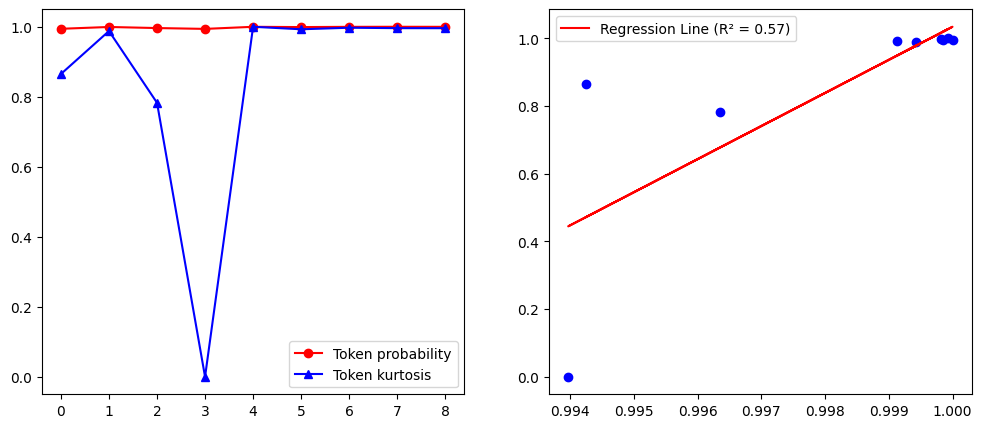

--------------- Sample 1 ---------------


62it [00:00, 1427.59it/s]


[Sentences]
   Input: translate English to German: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
   True Translation: Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.
   Predicted Translation: Ich erkläre die am Freitag, dem 17. Dezember 1999 unterbrochene Sitzungsperiode des Europäischen Parlaments für wieder aufgenommen, und ich möchte Ihnen erneut ein glückliches neues Jahr wünschen, in der Hoffnung, dass Sie einen angenehmen Festtag genießen.

[Scores]
   Adjusted BLEU score: 0.5582440606659764
   Adjusted METEOR score: 0.7037388031565639
   ROUGE score: {'rouge-1': {'precision': 0.7045341618209043, 'recall': 0.6396114971928488, 'f1-score': 0.6705049367885

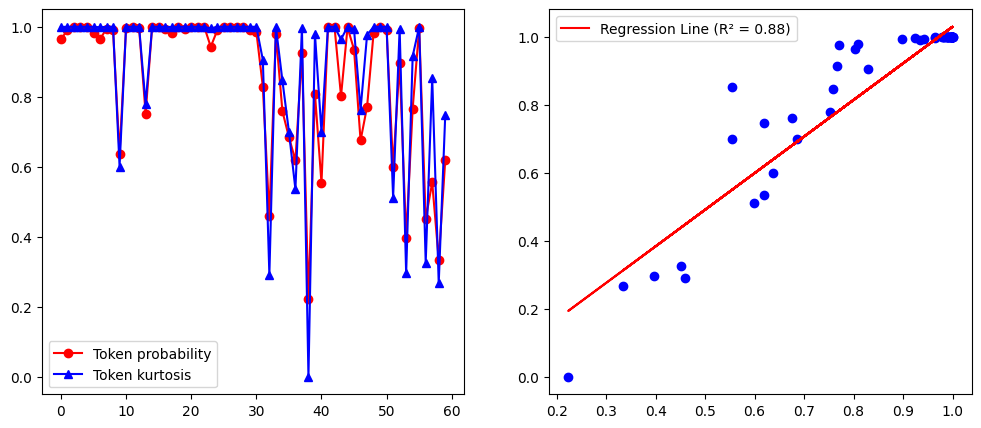

--------------- Sample 2 ---------------


65it [00:00, 1366.96it/s]

[Sentences]
   Input: translate English to German: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
   True Translation: Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.
   Predicted Translation: Obwohl, wie Sie gesehen haben, der gefürchtete "Millennium-Fehler" nicht zustande kam, erlitten die Menschen in einigen Ländern noch immer eine Reihe von Naturkatastrophen, die wirklich schrecklich waren.

[Scores]
   Adjusted BLEU score: 0.2819358662795108
   Adjusted METEOR score: 0.5282573176819452
   ROUGE score: {'rouge-1': {'precision': 0.4549987587698136, 'recall': 0.4505968263801351, 'f1-score': 0.4527870940860015}, 'rouge-2': {'precision': 0.3042915981882344, 'recall': 0.295201883938897, 'f1-score': 0.29967783

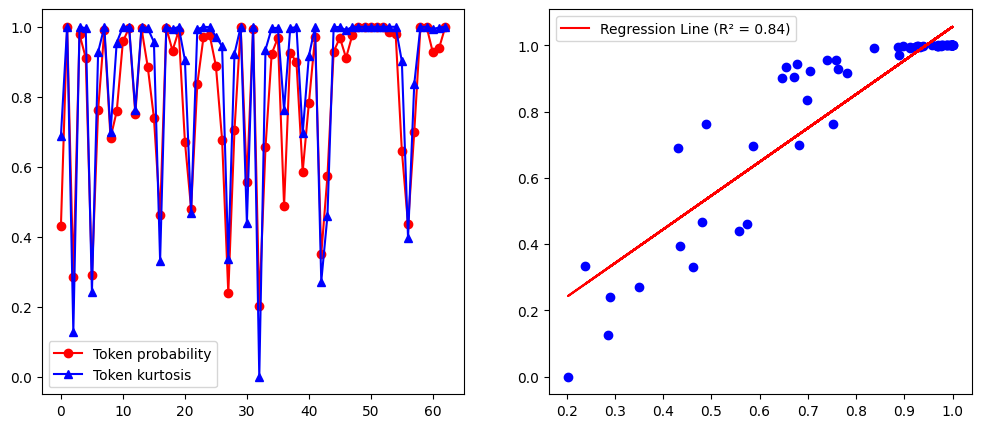

--------------- Sample 3 ---------------


28it [00:00, 1427.76it/s]

[Sentences]
   Input: translate English to German: You have requested a debate on this subject in the course of the next few days, during this part-session.
   True Translation: Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.
   Predicted Translation: Sie haben in den nächsten Tagen, während dieser Sitzung, eine Aussprache zu diesem Thema beantragt.

[Scores]
   Adjusted BLEU score: 0.25770973618813114
   Adjusted METEOR score: 0.43775491491360563
   ROUGE score: {'rouge-1': {'precision': 0.4520826501873829, 'recall': 0.38300372075348765, 'f1-score': 0.4146860567602896}, 'rouge-2': {'precision': 0.326912869101536, 'recall': 0.2714410288319984, 'f1-score': 0.2966056236411395}, 'rouge-l': {'precision': 0.23898982285700368, 'recall': 0.20247180522870759, 'f1-score': 0.21922041593953326}}
   BERT score: {'precision': [0.8852511644363403], 'recall': [0.8957069516181946], 'f1': [0.8904483318328857], 'hashcode': 'distilbert-base-m

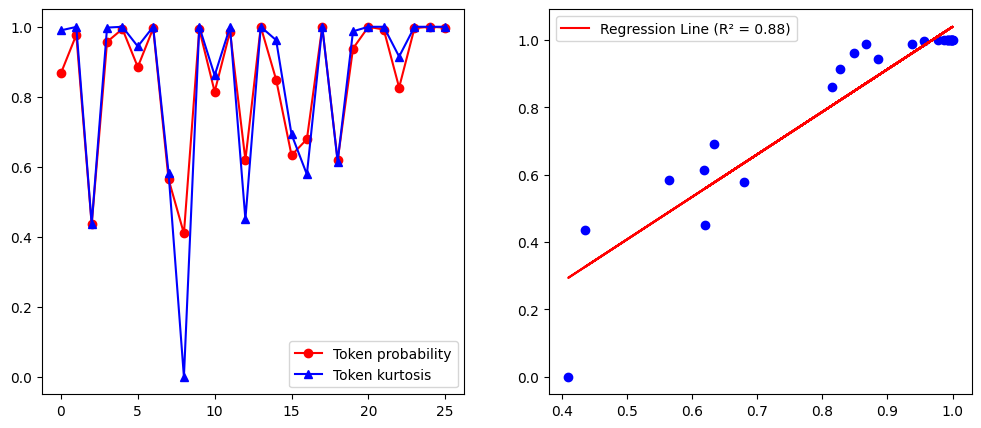

--------------- Sample 4 ---------------


58it [00:00, 1527.39it/s]

[Sentences]
   Input: translate English to German: In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.
   True Translation: Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.
   Predicted Translation: In der Zwischenzeit möchte ich, wie einige Abgeordnete es gefordert haben, im Namen aller betroffenen Opfer, insbesondere der schrecklichen Stürme, in den verschiedenen Ländern der Europäischen Union eine Schweigeminute einlegen.

[Scores]
   Adjusted BLEU score: 0.31105237670145125
   Adjusted METEOR score: 0.5521024959872664
   ROUGE score: {'rouge-1': {'precision': 0.5736560938864282, 'recall': 0.49702700136501365, 'f1-score': 0.532599364692835

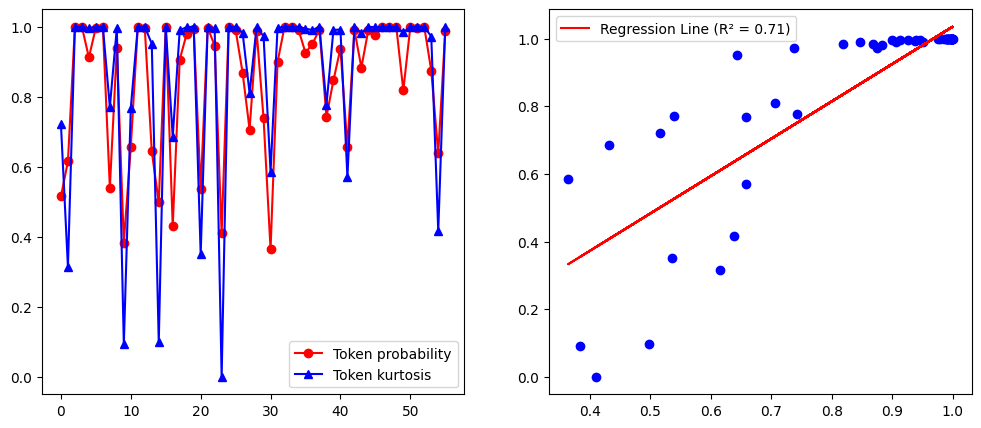

In [8]:
for i in range(5):
    print(f"--------------- Sample {i} ---------------")
    input_text = f"translate English to German: {ds_de_en['train'][i]['translation']['en']}"
    true_translation = ds_de_en['train'][i]['translation']['de']
    predicted_translation, token_probs, token_kurtosis = generate_output_with_probs(model=t5_model_small, tokenizer=t5_tokenizer_small, example=input_text)

    # tokenize 
    true_tokens = t5_tokenizer_small.tokenize(true_translation)
    predicted_tokens = t5_tokenizer_small.tokenize(predicted_translation)

    # print(len(true_tokens))
    # print(len(predicted_tokens))
    # print(len(token_probs))

    # uncertainty quantification using kurtosis 
    token_kurtosis = token_kurtosis.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_token_kurtosis = scaler.fit_transform(token_kurtosis).flatten() 
    
    # already available metrics
    bleu   = adjusted_bleu_score(true_tokens, predicted_tokens, token_probs) 
    meteor = adjusted_meteor_score([true_tokens],                                
                                   predicted_tokens, 
                                   token_probs,
                                   preprocess=str.lower,
                                   stemmer=PorterStemmer(),
                                   wordnet=wordnet,
                                   alpha=0.9,
                                   beta=3.0,
                                   gamma=0.5
                                   )                                            
    rouge  = adjusted_rouge_score(true_tokens,                             
                                  predicted_tokens, 
                                  token_probs,
                                  ngram_orders=[1, 2])
    
    

    bert = bertscore.compute(predictions=[predicted_translation], references=[true_translation], model_type='distilbert-base-multilingual-cased') # 4. BERTscore.

    # print results
    print("[Sentences]")
    print("   Input:", input_text)
    print("   True Translation:", true_translation)
    print("   Predicted Translation:", predicted_translation)

    print("\n[Scores]")
    print("   Adjusted BLEU score:", bleu)
    print("   Adjusted METEOR score:", meteor)
    print("   ROUGE score:", rouge)
    print("   BERT score:", bert)

    print("\n[Uncertainty Quantification]")
    # print(f"   Token length: {len(token_probs)}")
    print(f"   Top 1 token probabilities (Geometric mean): {np.round(gmean(token_probs), 3)}")
    print(f"   Top 1 token probabilities: {np.round(token_probs, 3)}")
    print(f"   Scaled kurtosis: {np.round(scaled_token_kurtosis, 3)}")
    # print(f"   Top 1 token probabilities (Harmonic mean): {np.round(hmean(token_probs), 3)}")

    # visualization for token probability and kurtosis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(np.arange(0, len(token_probs)), token_probs, label='Token probability', c='red', marker='o')
    ax1.plot(np.arange(0, len(token_probs)), scaled_token_kurtosis, label='Token kurtosis', c='blue', marker='^')
    ax1.legend()

    model = LinearRegression()
    model.fit(token_probs.reshape(-1, 1), scaled_token_kurtosis)
    predictions = model.predict(token_probs.reshape(-1, 1))
    r2 = r2_score(scaled_token_kurtosis, predictions)
    ax2.scatter(token_probs, scaled_token_kurtosis, color='blue')
    ax2.plot(token_probs, predictions, color='red', label=f'Regression Line (R² = {r2:.2f})')
    ax2.legend()
    plt.show()
